# Lab 3.1: Friends/Followers

This lab covers how to retrieve lists of accounts who *follow* (followers) or *get followed by* (friends) specific Twitter users. More specifically, this lab introduces the functions `get_friends()` and `get_followers()` from the [{rtweet}](http://rtweet.info) package.

To use rtweet, first source the `rlib.R` script and then load the package using the code below.

In [1]:
## source rlib script (install and store rtweet)
source("../rlib.R")

## load rtweet
library(rtweet)

## get_friends()

In Twitter's API documentation, **friends** refer to the accounts a user follows. To get a list a user's friends (all the accounts a user follows), use the `get_friends()` function from rtweet. `get_friends()` returns a list of user IDs for up to 5,000 accounts followed by a given user. 

*Note*: Twitter actually limits the number of accounts a user can follow to 5,000. To follow more than 5,000, users must maintain a ratio of followers to friends of roughly 1.0. So, between how hard it is to keep up with 5,000 accounts to begin with and Twitter's cap on friends, the vast majority of users follow fewer than 5,000 accounts.

For an example, we'll get the list of accounts followed by jack, the co-founder and CEO of Twitter.

In [2]:
## get status IDs of jack's friend's
fds <- get_friends("jack")

Data are returned by `get_friends()` as a data frame consisting of two columns

In [3]:
## user (user) and user_id (friends)
head(fds, 10)

user,user_id
jack,4658336942
jack,21848184
jack,564048720
jack,22178780
jack,36381677
jack,301708139
jack,3254857712
jack,3367231463
jack,15871688
jack,174316017


It's possible to get the friends list from multiple users.

In [4]:
## get frieds of data scientists
fds <- get_friends(c("hadleywickham", "hrbrmstr", "calbon", "dataandme", "rOpenSci", "jack", "NateSilver538"))

1 friend networks collected!
2 friend networks collected!
3 friend networks collected!
4 friend networks collected!
5 friend networks collected!
6 friend networks collected!
7 friend networks collected!


The ease in which one can collect network data makes Twitter especially condusive to network analysis. A quick example of this kind of analysis is done below.

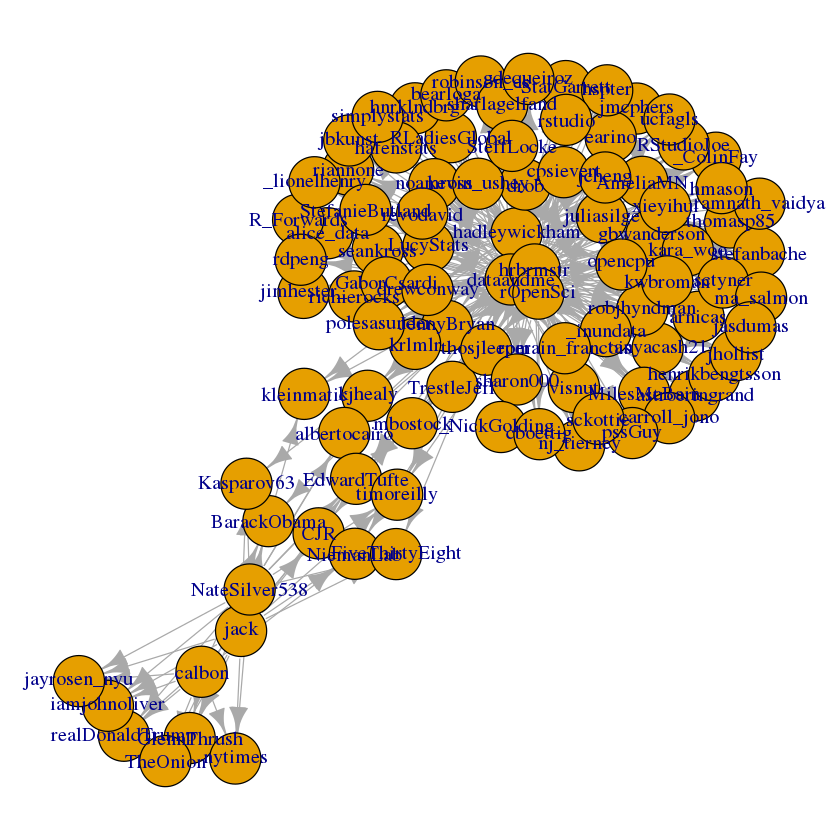

In [5]:
## frequency count of accounts followed by the users queried above
tbl <- table(fds$user_id)

## identify all accounts followed by at least 3 of the queried users
fds_mult <- names(tbl[tbl > 2L])

## use the `lookup_users()` function to get more data on the users (e.g., screen names)
fds_mult_df <- lookup_users(fds_mult)

## subset fds data to only those followed by 3 or more
fds3 <- subset(fds, user_id %in% fds_mult)

## convert fds3 to matrix
mat <- as.matrix(fds3)

## replace user IDs with screen names
mat[, 2] <- fds_mult_df$screen_name[match(fds3$user_id, fds_mult_df$user_id)]

## convert to graph object
mat <- igraph::graph_from_edgelist(mat)

## plot network
par(mar = c(1, 1, 1, 1))
plot(mat)

But the rate limit---15 requests every 15 minutes---is rather restrictive. One way to deal with these rate limits is to construct a for loop with a sleep call like the one in the example below. In this code, the goal was to retrieve all of the accounts followed by the friends of @realDonaldTrump. In other words, the friends of Trump's friends.

In [6]:
## get all of trump's friends
trump_fds <- get_friends("realdonaldtrump")

## initialize output vector
trump_fds_fds <- vector("list", nrow(trump_fds))

## for loop with sleep in it
for (i in seq_along(trump_fds_fds)) {
    trump_fds_fds[[i]] <- get_friends(trump_fds$user_id[i])
    ## sleep every 15 calls for 15 minutes (but never on the last call)
    if (i %% 15 == 0 && i != length(trump_fds_fds)) {
        Sys.sleep(60 * 15)
    }
}

## combine in single data frame
trump_fds_fds <- do.call("rbind", trump_fds_fds)

Warning message:
"Rate limit exceeded"Warning message:
"Rate limit exceeded"Warning message:
"Rate limit exceeded"Warning message:
"Rate limit exceeded"Warning message:
"Rate limit exceeded"Warning message:
"Rate limit exceeded"Warning message:
"Rate limit exceeded"Warning message:
"Rate limit exceeded"Warning message:
"Rate limit exceeded"

The next lab ([lab 3.2](users.ipynb)) covers how to retrieve the full **users** data set from Twitter's API using a list of user IDs---like the ones returned to us above!

## get_followers()

In Twitter's API documentation, **follower** refers to accounts following a given user. Using the rtweet package, one can easily retrieve a list of accounts following a specified user using the `get_followers()` function. For example, the code below gets all the users who follow me on Twitter.

In [7]:
kmw <- get_followers("kearneymw")

As you can see, the data look similar to the data returned by `get_friends()`.

In [8]:
head(kmw, 10)

user_id
2152494658
139613007
266379957
38341407
582834654
3285994886
392067270
891715872498364416
19087350
2902816824


In a lot of ways, the `get_followers()` function is very similar to `get_friends()`. The major difference between the two functions has to do with the fact that while nearly all users follow fewer than 5,000 accounts, there are many accounts that have lots and lots of followers. As a consequence, `get_followers()` is designed to return potentially large amounts of followers in a single request. In addition, the rate limit for the number of followers a user can request every 15 minutes works out to be much larger. Whereas with `get_friends()` users are limited to up to 5,000 friends (user IDs) of 15 accounts (request), with `get_followers()` users are again limited to 15 requests that each return up to 5,000 user IDs. However, because we're typically interested in accounts with lots of followers, this most often manifests as a limit on how many followers one can request for a *single* account (rather than a limit on the number of total accounts requested). In other words, we can get up to 75,000 followers for a user every 15 minutes.

So, for example, if we wanted to get all of the users following Donald Trump, we'd expect the following code, which asks for up to 50 million of @realdonaldtrump's followers, to take about five and a half days:

In [9]:
## get all of trump's followers
rdt <- get_followers("realdonaldtrump", n = 5e7)

Of course, because he's followed by around 40 million users, the time it takes to complete this request (almost 6 days) might create some problems as it relies on a stable internet connection, etc.

Sometimes, then, it's safer to [again] write a for loop with a built-in sleep call. As an example of this, I've written the code below to loop through 75000 of trump's followers at a time.

In [10]:
## initialize parameter (start at NULL and update once we have some data)
page <- NULL

## initialize output vector (change 2 to a lot larger number for more followers)
out <- vector("list", 2)

## create output data directory
dir.create("rdt-followers")

## loop through followers, sleeping after every call
for (i in seq_along(out)) {
    ## get followers
    out[[i]] <- get_followers("realdonaldtrump", n = 75000, page = page)
    ## save file
    saveRDS(out[[i]], paste0("rdt-followers/rdt", i, ".rds"))
    ## update cursor param
    page <- next_cursor(out[[i]])
    ## break if cursor is null or if last loop
    if (is.null(page) || i == length(out)) {
        break
    }
    ## sleep with message
    message("Waiting 15 mins for rate limit reset...")
    Sys.sleep(60 * 15)
}

To then read all the data files and merge them into a single data frame, you could use the code below.

In [11]:
## list all RDS (R data) files in data directory
files <- list.files("rdt-followers", full.names = TRUE, pattern = "\\.rds$")

## initailize output vector
rdt <- lapply(files, readRDS)

## collapse into single data frame
rdt <- do.call("rbind", rdt)